In [1]:
import numpy as np
import matplotlib.pyplot as plt
from problem_1.FEMpoisson import *
from problem_2.OCP import *


                                                  Convergence Analysis                                                  
     M           h        L2 Error    Rate L2     Ratio L2    H1 Error    Rate H1     Ratio H1  
------------------------------------------------------------------------------------------------------------------------
     4        2.50e-01    8.81e-17       -           -        3.09e-16       -           -      
     8        1.25e-01    3.73e-16     -2.08        0.24      1.21e-15     -1.97        0.26    
     16       6.25e-02    1.83e-15     -2.30        0.20      5.80e-15     -2.26        0.21    
     32       3.12e-02    7.05e-15     -1.94        0.26      2.22e-14     -1.94        0.26    
     64       1.56e-02    2.83e-14     -2.01        0.25      8.91e-14     -2.01        0.25    
    128       7.81e-03    1.06e-13     -1.91        0.27      3.34e-13     -1.91        0.27    
    256       3.91e-03    4.26e-13     -2.00        0.25      1.34e-12     -2.

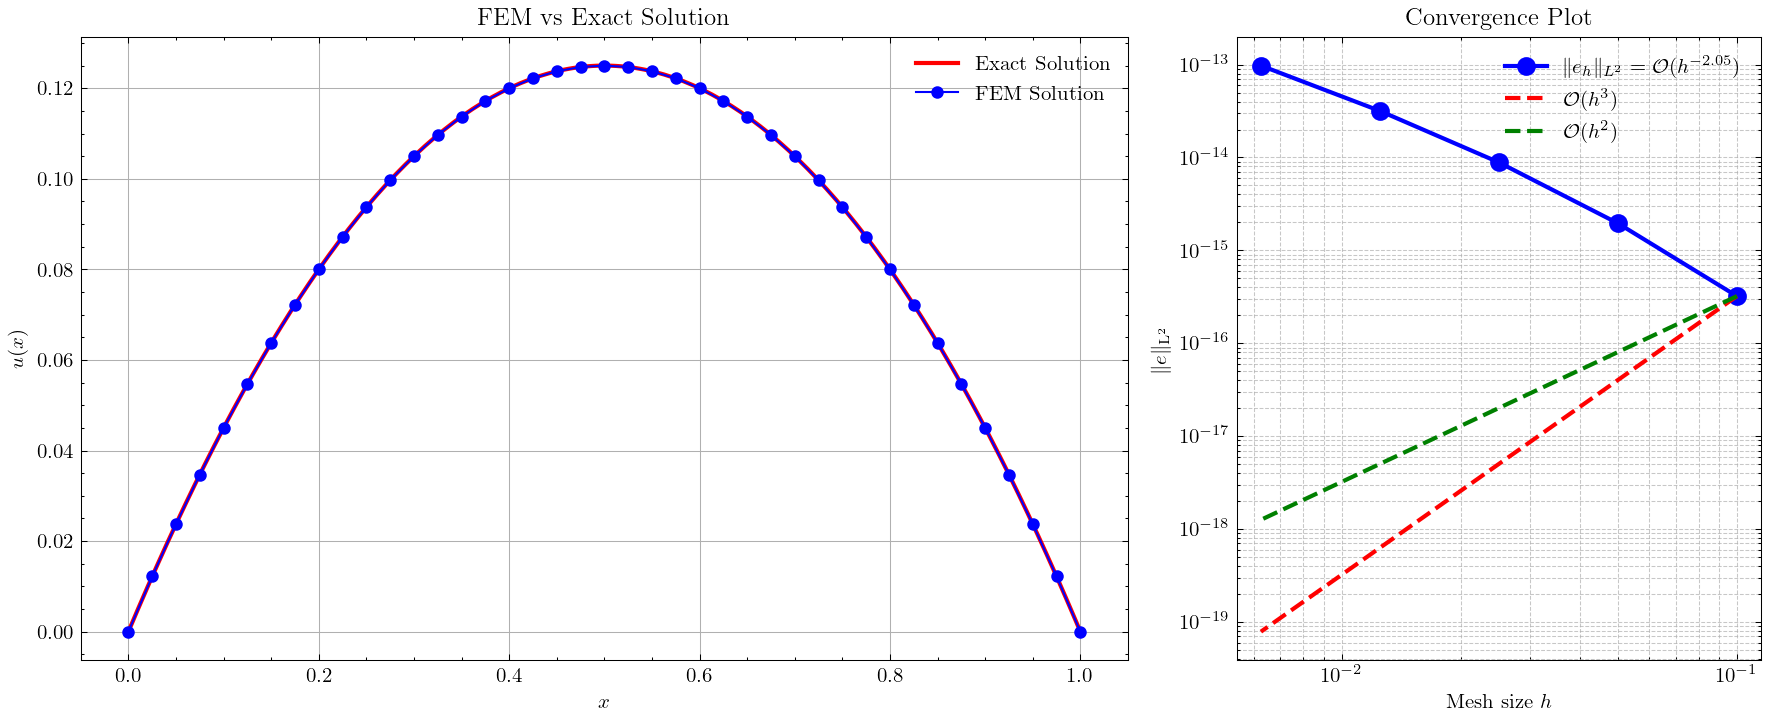

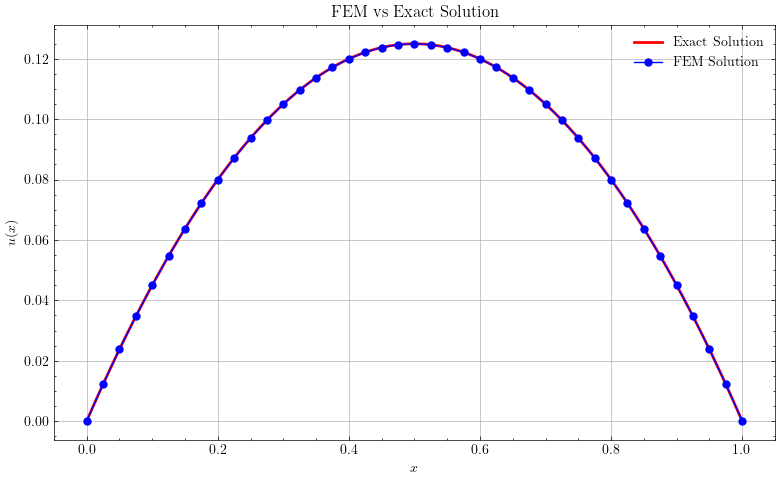

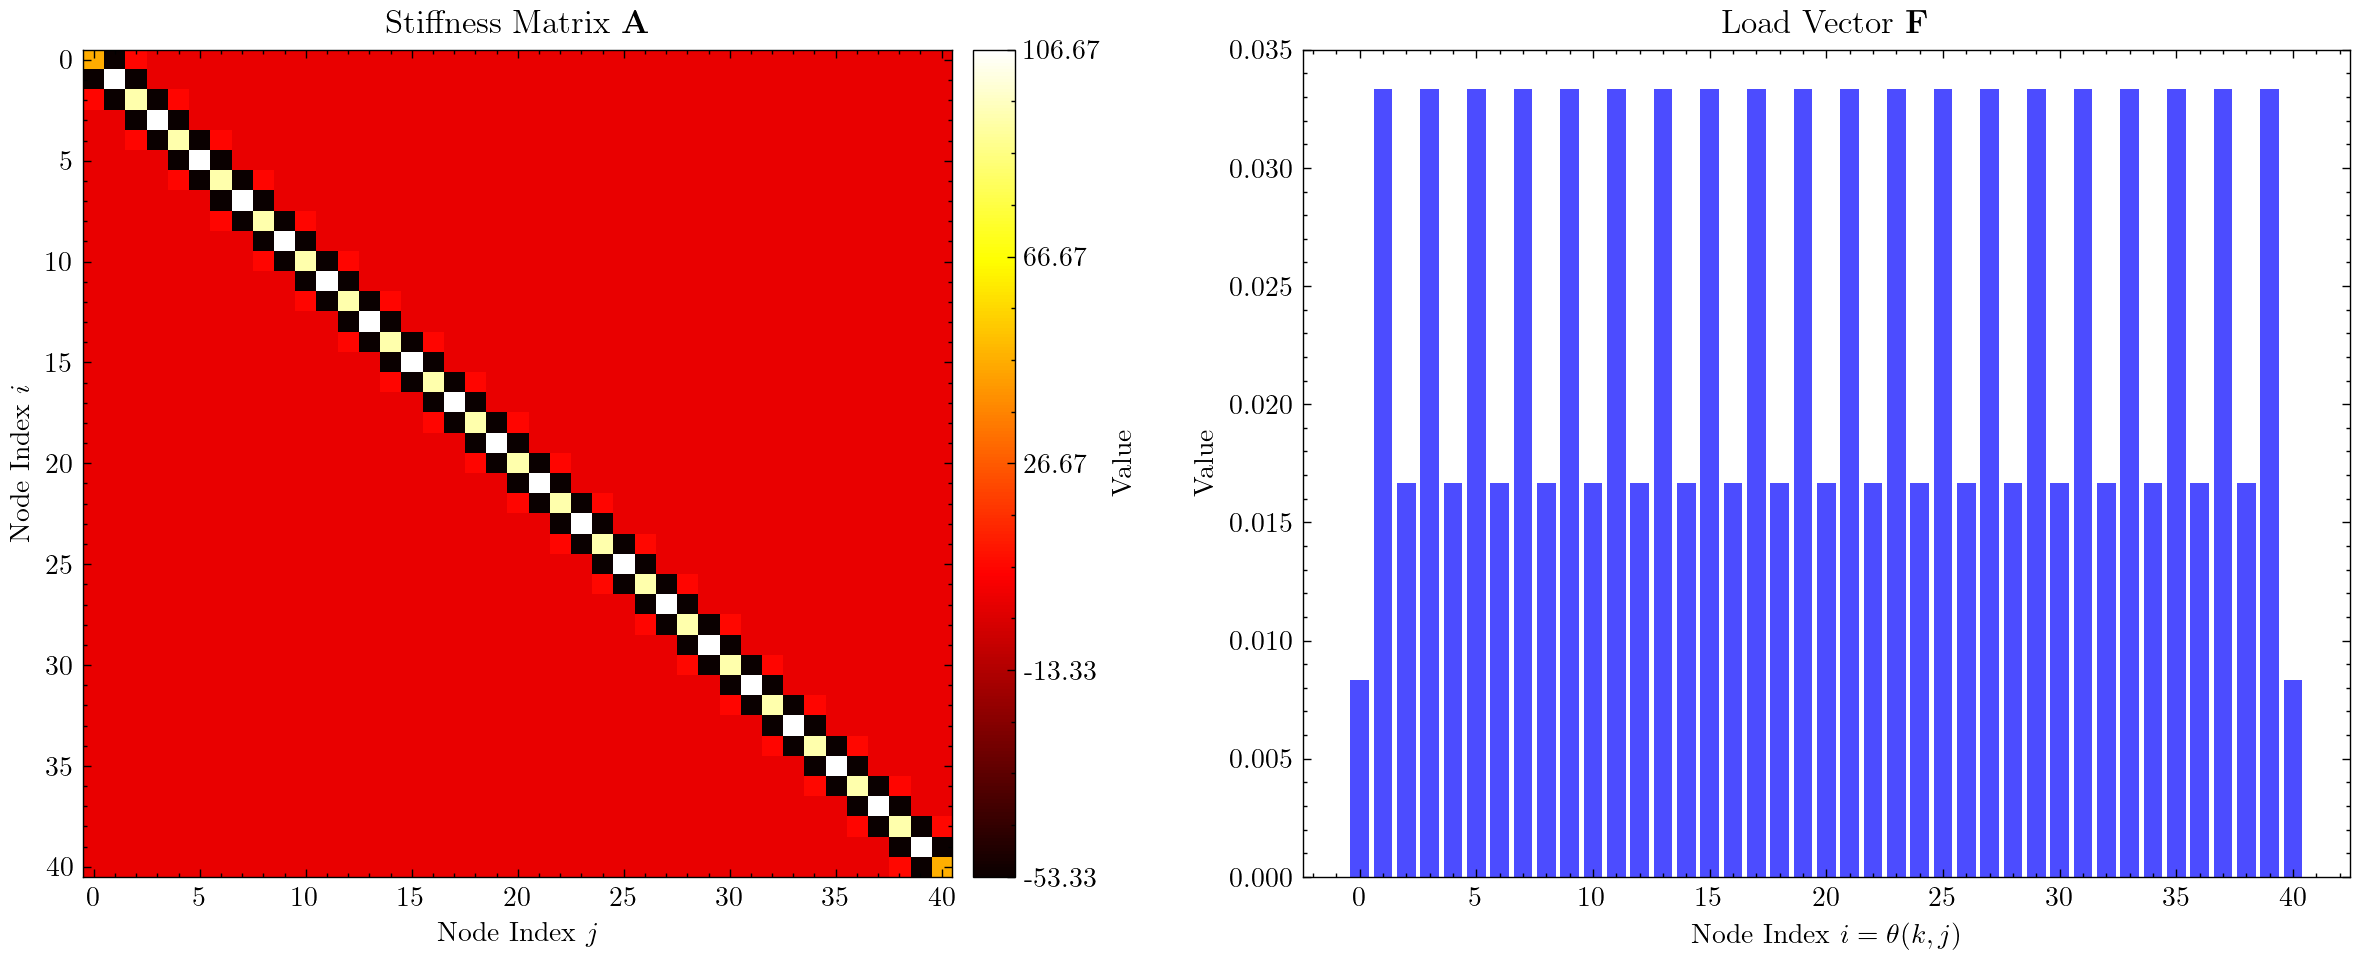

In [2]:
f1 = lambda x: 1.0
exact1 = lambda x: x*(1-x)/2
du_exact1 = lambda x: 0.5 - x
ddu_exact1 = lambda x: -1.0

savefig = False
ex1 = FEMPoissonSolver(M=20, f=f1, exact=exact1, du_exact=du_exact1, ddu_exact=ddu_exact1)
ex1.assemble()
ex1.solve()
print_convergence_table(ex1)
plot(ex1, name='simple', savefig=savefig)
plot_solution(ex1, name='simple', savefig=savefig)
plot_stiffness_matrix_and_load_vector(ex1, name='simple', savefig=savefig)


                                                  Convergence Analysis                                                  
     M           h        L2 Error    Rate L2     Ratio L2    H1 Error    Rate H1     Ratio H1  
------------------------------------------------------------------------------------------------------------------------
     4        2.50e-01    3.89e-04       -           -        8.08e-02       -           -      
     8        1.25e-01    2.39e-05      4.03       16.29      2.02e-02      2.00        4.00    
     16       6.25e-02    1.48e-06      4.01       16.07      5.05e-03      2.00        4.00    
     32       3.12e-02    9.27e-08      4.00       16.02      1.26e-03      2.00        4.00    
     64       1.56e-02    5.79e-09      4.00       16.00      3.15e-04      2.00        4.00    
    128       7.81e-03    3.62e-10      4.00       16.02      7.89e-05      2.00        4.00    
    256       3.91e-03    2.12e-11      4.09       17.06      1.97e-05      2.

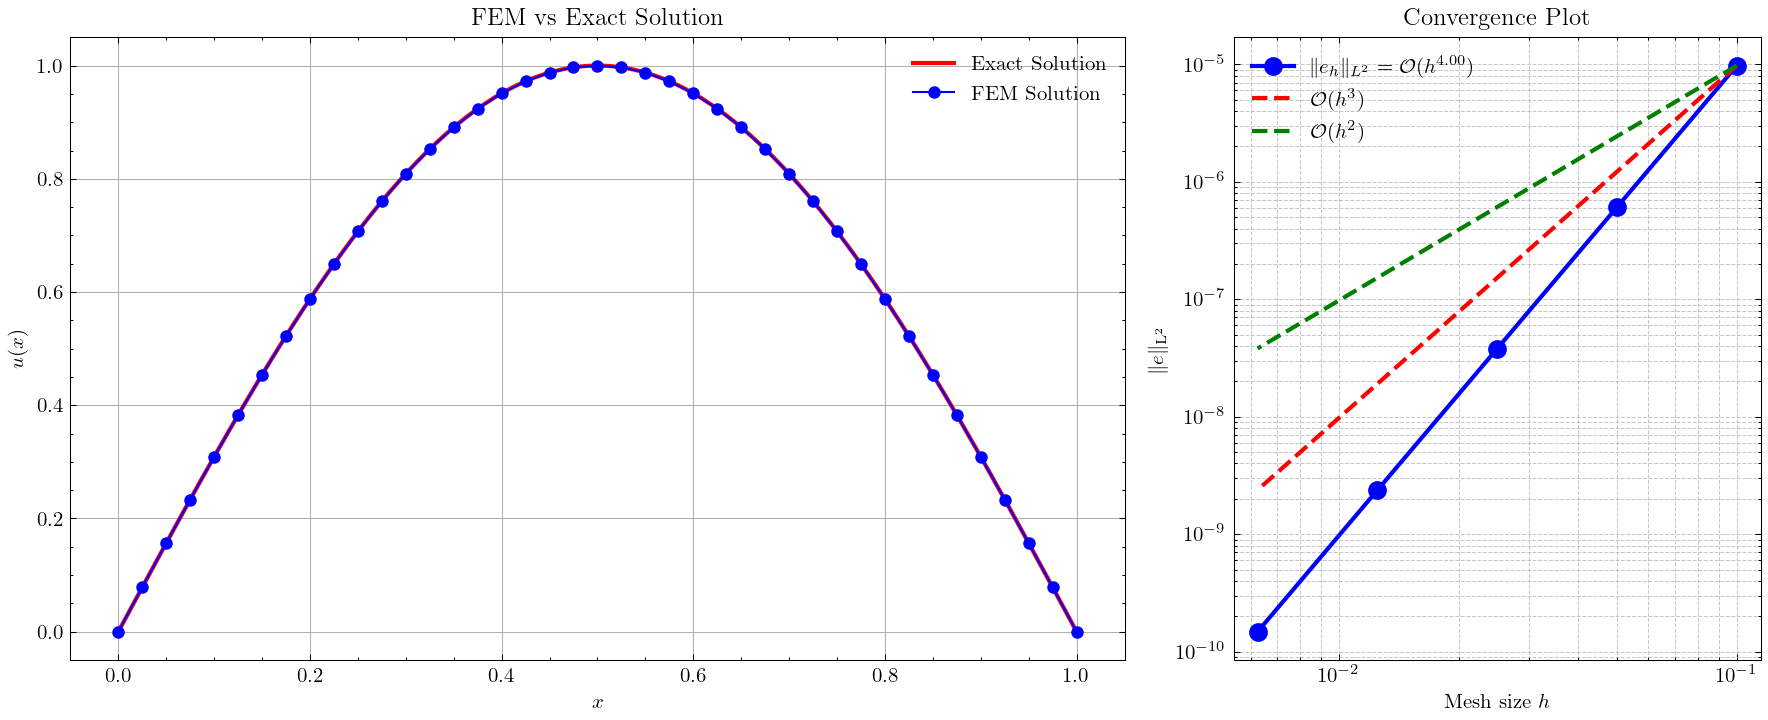

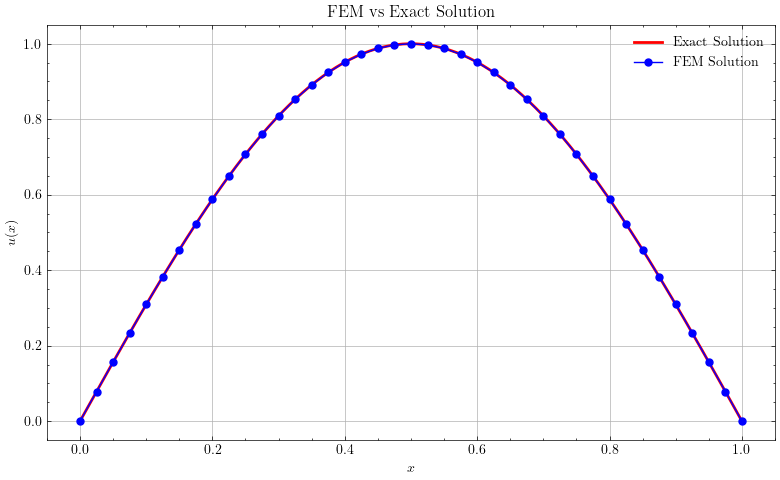

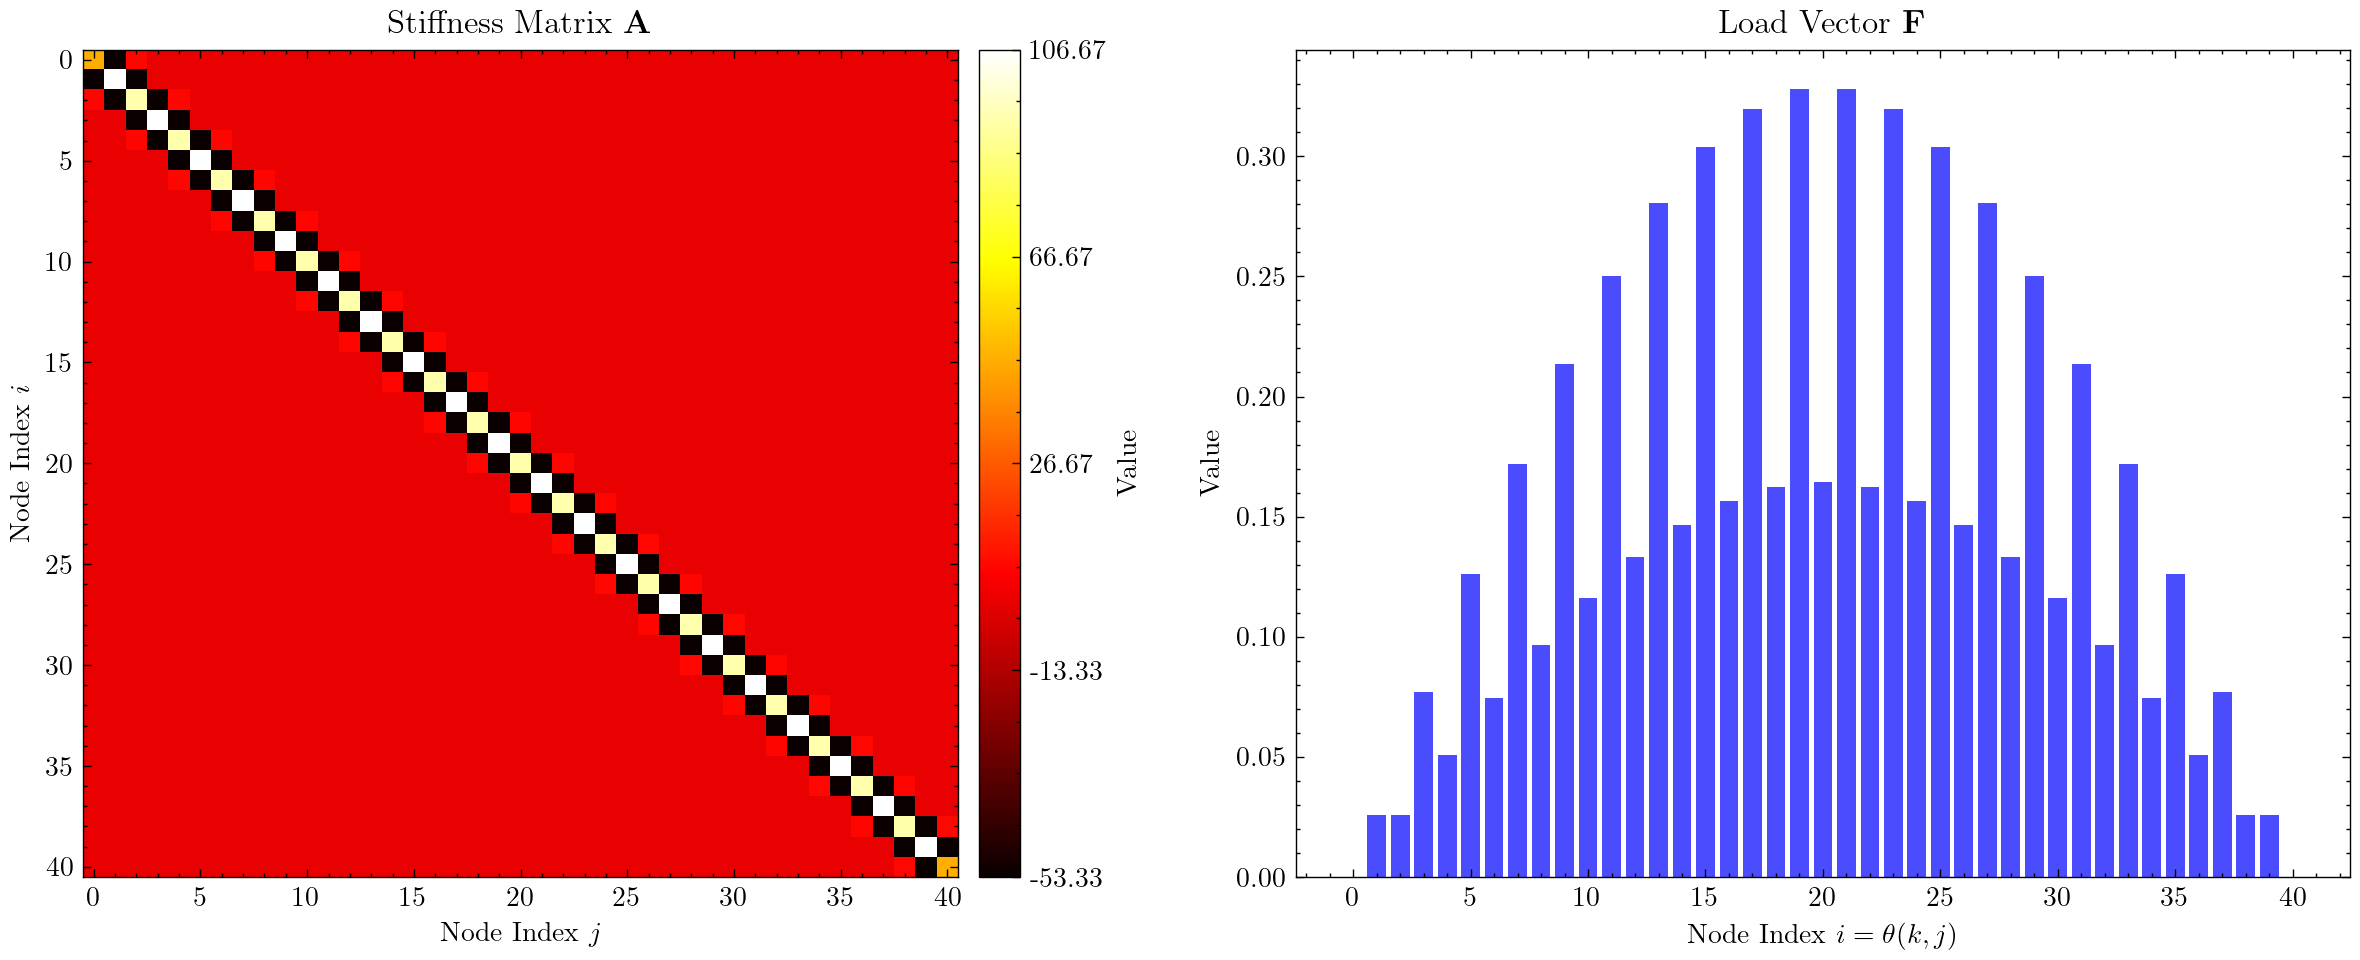

In [3]:

f2 = lambda x: np.pi**2 * np.sin(np.pi*x)
exact2 = lambda x: np.sin(np.pi*x)
du_exact2 = lambda x: np.pi * np.cos(np.pi*x)
ddu_exact2 = lambda x: -np.pi**2 * np.sin(np.pi*x)

savefig2= False
solver2 = FEMPoissonSolver(M=20, f=f2, exact=exact2, du_exact=du_exact2, ddu_exact=ddu_exact2)
solver2.assemble()
solver2.solve()
print_convergence_table(solver2)
plot(solver2, name='sin', savefig=savefig2)
plot_solution(solver2, name='sin', savefig=savefig2)
plot_stiffness_matrix_and_load_vector(solver2, name='sin', savefig=savefig2)



In [4]:
solver2 = FEMPoissonSolver(M=5, f=f2, exact=exact2, du_exact=du_exact2, ddu_exact=ddu_exact2)
solver2.assemble()
solver2.solve()
print_convergence_table(solver2)


                                                  Convergence Analysis                                                  
     M           h        L2 Error    Rate L2     Ratio L2    H1 Error    Rate H1     Ratio H1  
------------------------------------------------------------------------------------------------------------------------
     4        2.50e-01    3.89e-04       -           -        8.08e-02       -           -      
     8        1.25e-01    2.39e-05      4.03       16.29      2.02e-02      2.00        4.00    
     16       6.25e-02    1.48e-06      4.01       16.07      5.05e-03      2.00        4.00    
     32       3.12e-02    9.27e-08      4.00       16.02      1.26e-03      2.00        4.00    
     64       1.56e-02    5.79e-09      4.00       16.00      3.15e-04      2.00        4.00    
    128       7.81e-03    3.62e-10      4.00       16.02      7.89e-05      2.00        4.00    
    256       3.91e-03    2.12e-11      4.09       17.06      1.97e-05      2.

In [5]:
def f_test3(x): return np.exp(x)
def u_exact_test3(x): return -np.exp(x) + (np.e - 1)*x + 1
def du_exact_test3(x): return -np.exp(x) + (np.e - 1)
def ddu_exact_test3(x): return -np.exp(x)
savefig3 = False
solver3 = FEMPoissonSolver(M=5, f=f_test3, exact=u_exact_test3, du_exact=du_exact_test3, ddu_exact=ddu_exact_test3)
solver3.assemble()
solver3.solve()
print_convergence_table(solver3)


                                                  Convergence Analysis                                                  
     M           h        L2 Error    Rate L2     Ratio L2    H1 Error    Rate H1     Ratio H1  
------------------------------------------------------------------------------------------------------------------------
     4        2.50e-01    1.52e-05       -           -        6.57e-03       -           -      
     8        1.25e-01    9.55e-07      3.99       15.92      1.64e-03      2.00        3.99    
     16       6.25e-02    5.97e-08      4.00       15.98      4.11e-04      2.00        4.00    
     32       3.12e-02    3.74e-09      4.00       16.00      1.03e-04      2.00        4.00    
     64       1.56e-02    2.34e-10      4.00       16.00      2.57e-05      2.00        4.00    
    128       7.81e-03    1.47e-11      3.99       15.86      6.43e-06      2.00        4.00    
    256       3.91e-03    1.52e-12      3.28        9.71      1.61e-06      2.

In [6]:

def u_exact_test4(x):
    return (1.0 / (np.pi**2)) * np.sin(np.pi * x) + (1.0 / (4 * np.pi**2)) * np.sin(2 * np.pi * x)
def f_test4(x):
    return np.sin(np.pi * x) + np.sin(2 * np.pi * x)

savefig4 = False
solver4 = FEMPoissonSolver(M=20, f=f_test4, exact=u_exact_test4)
solver4.assemble()
solver4.solve()
solver4.print_convergence_table()
solver4.plot(fine_mesh=200, name='complex', savefig=savefig4)
solver4.plot_convergence(name='complex', savefig=savefig4)
solver4.plot_solution(name='complex', savefig=savefig4)

TypeError: FEMPoissonSolver.__init__() missing 2 required positional arguments: 'du_exact' and 'ddu_exact'

Convergence Table for yd_case1:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.006345        nan             nan             0.010392        nan             nan            
0.01       8          0.002499        1.344161        -2.881409       0.011326        -0.124173       -2.154724      
0.01       16         0.001064        1.232689        -2.469229       0.008266        0.454465        -1.729659      
0.01       32         0.000443        1.264415        -2.228266       0.005774        0.517517        -1.487231      
0.01       64         0.000185        1.255462        -2.066132       0.003827        0.593555        -1.338285      
0.01       128        0.000078        1.252804        -1.949942       0.002438        0.650127        -1.239976      
0.0001     4          0.000309        nan             nan             0.003475        nan             nan            
0.0001     8          0.

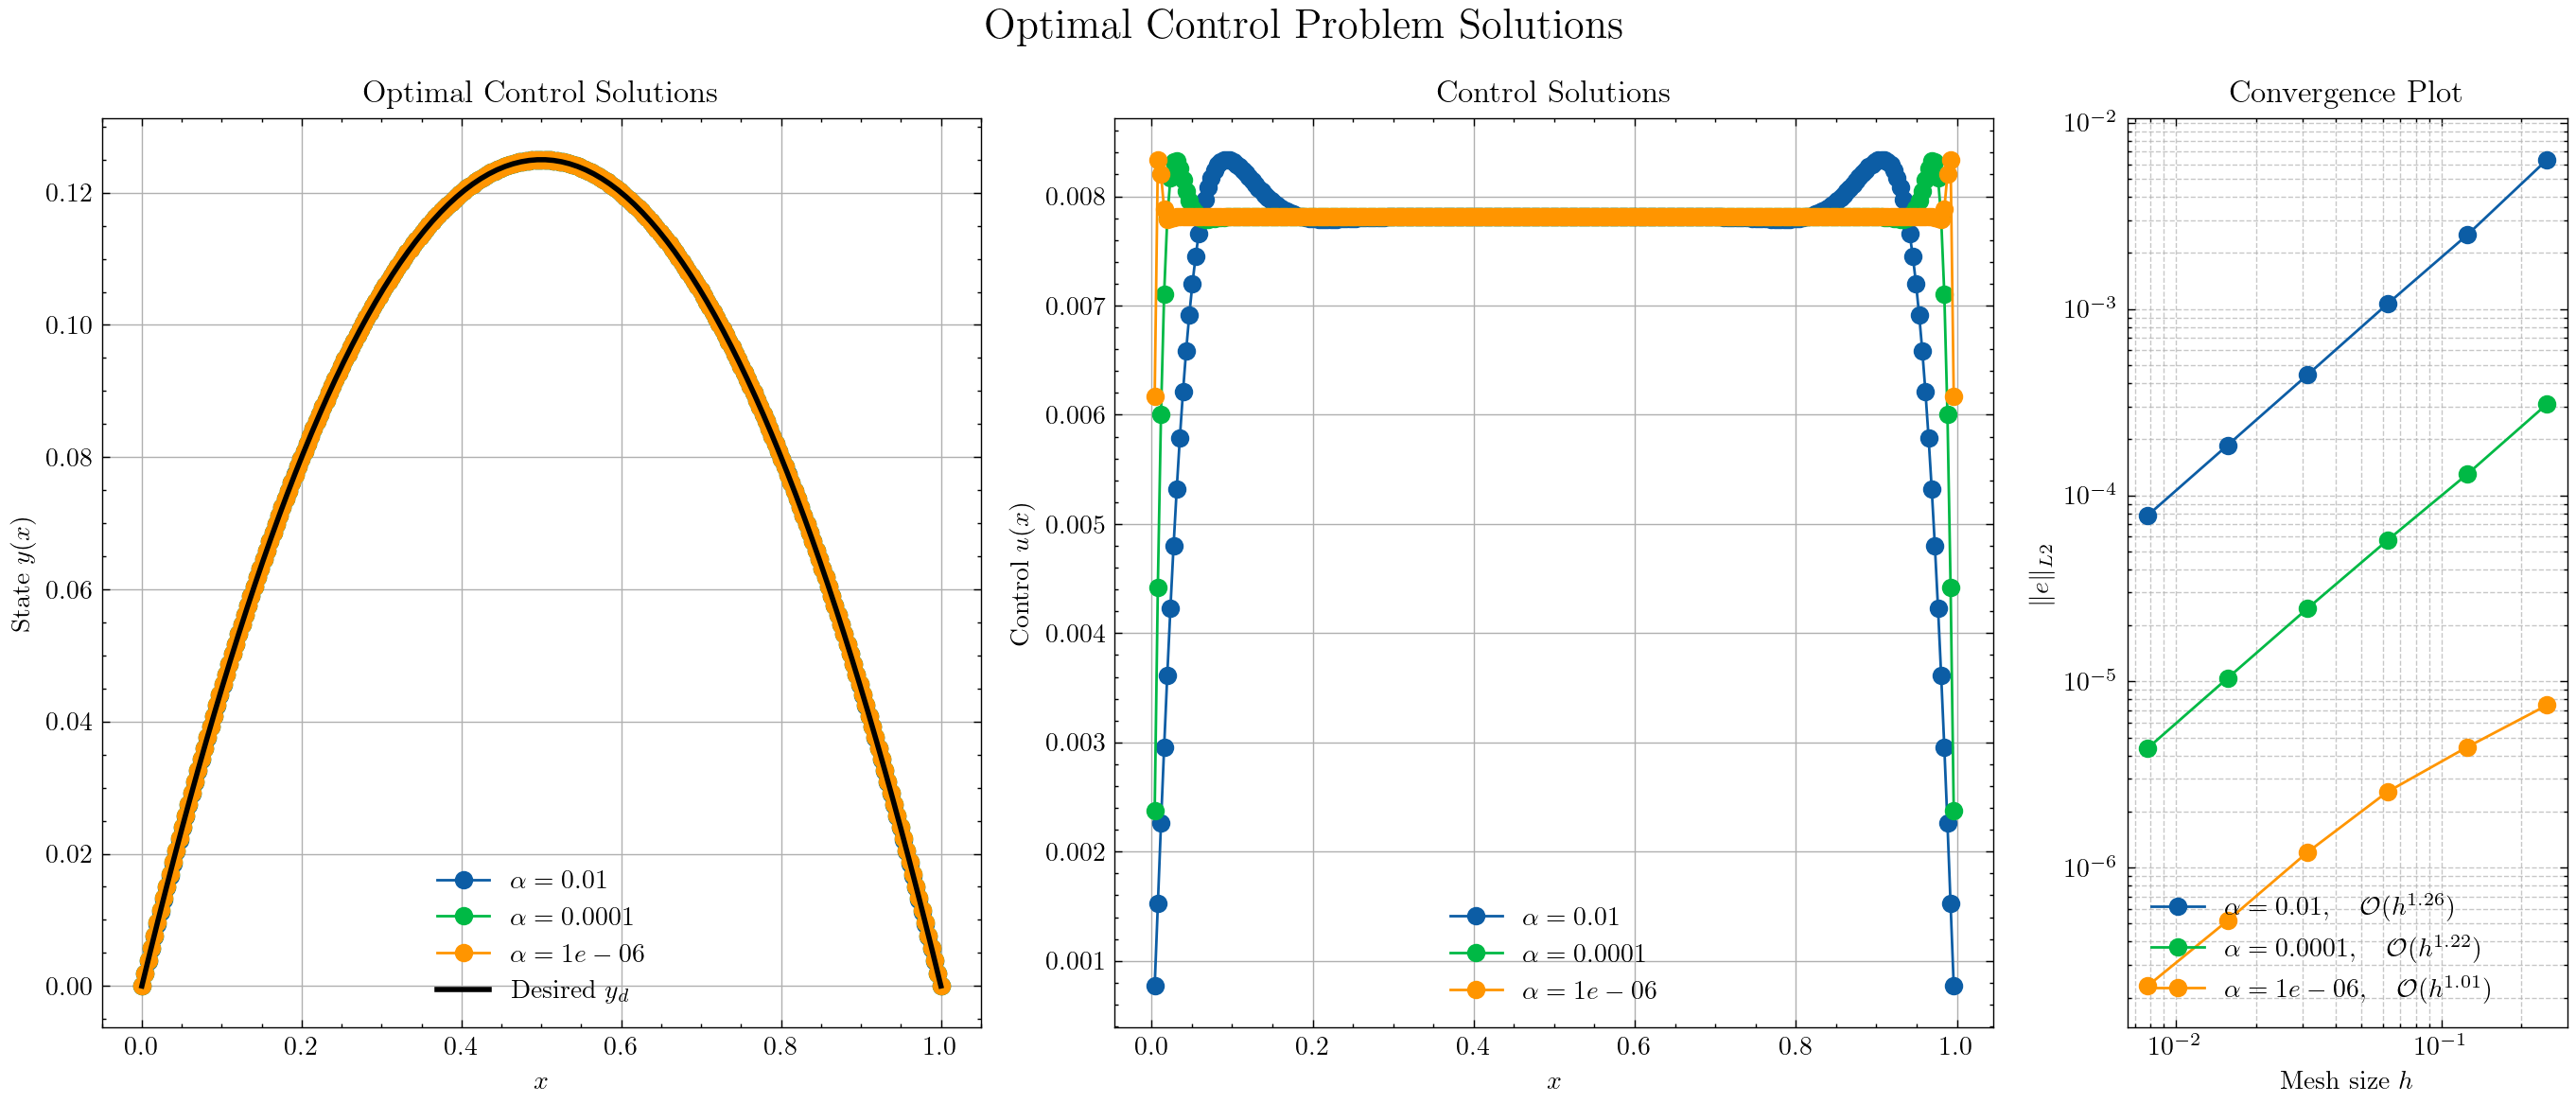



Convergence Table for yd_case2:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.270352        nan             nan             2.066545        nan             nan            
0.01       8          0.266085        0.022952        -0.636680       2.576473        -0.318176       0.455133       
0.01       16         0.239538        0.151631        -0.515418       3.272583        -0.345032       0.427607       
0.01       32         0.213174        0.168228        -0.445980       4.048530        -0.306968       0.403480       
0.01       64         0.186429        0.193402        -0.403883       4.931085        -0.284507       0.383651       
0.01       128        0.161157        0.210163        -0.376209       5.954926        -0.272178       0.367726       
0.0001     4          0.055638        nan             nan             0.671054        nan             nan            
0.0001     8          

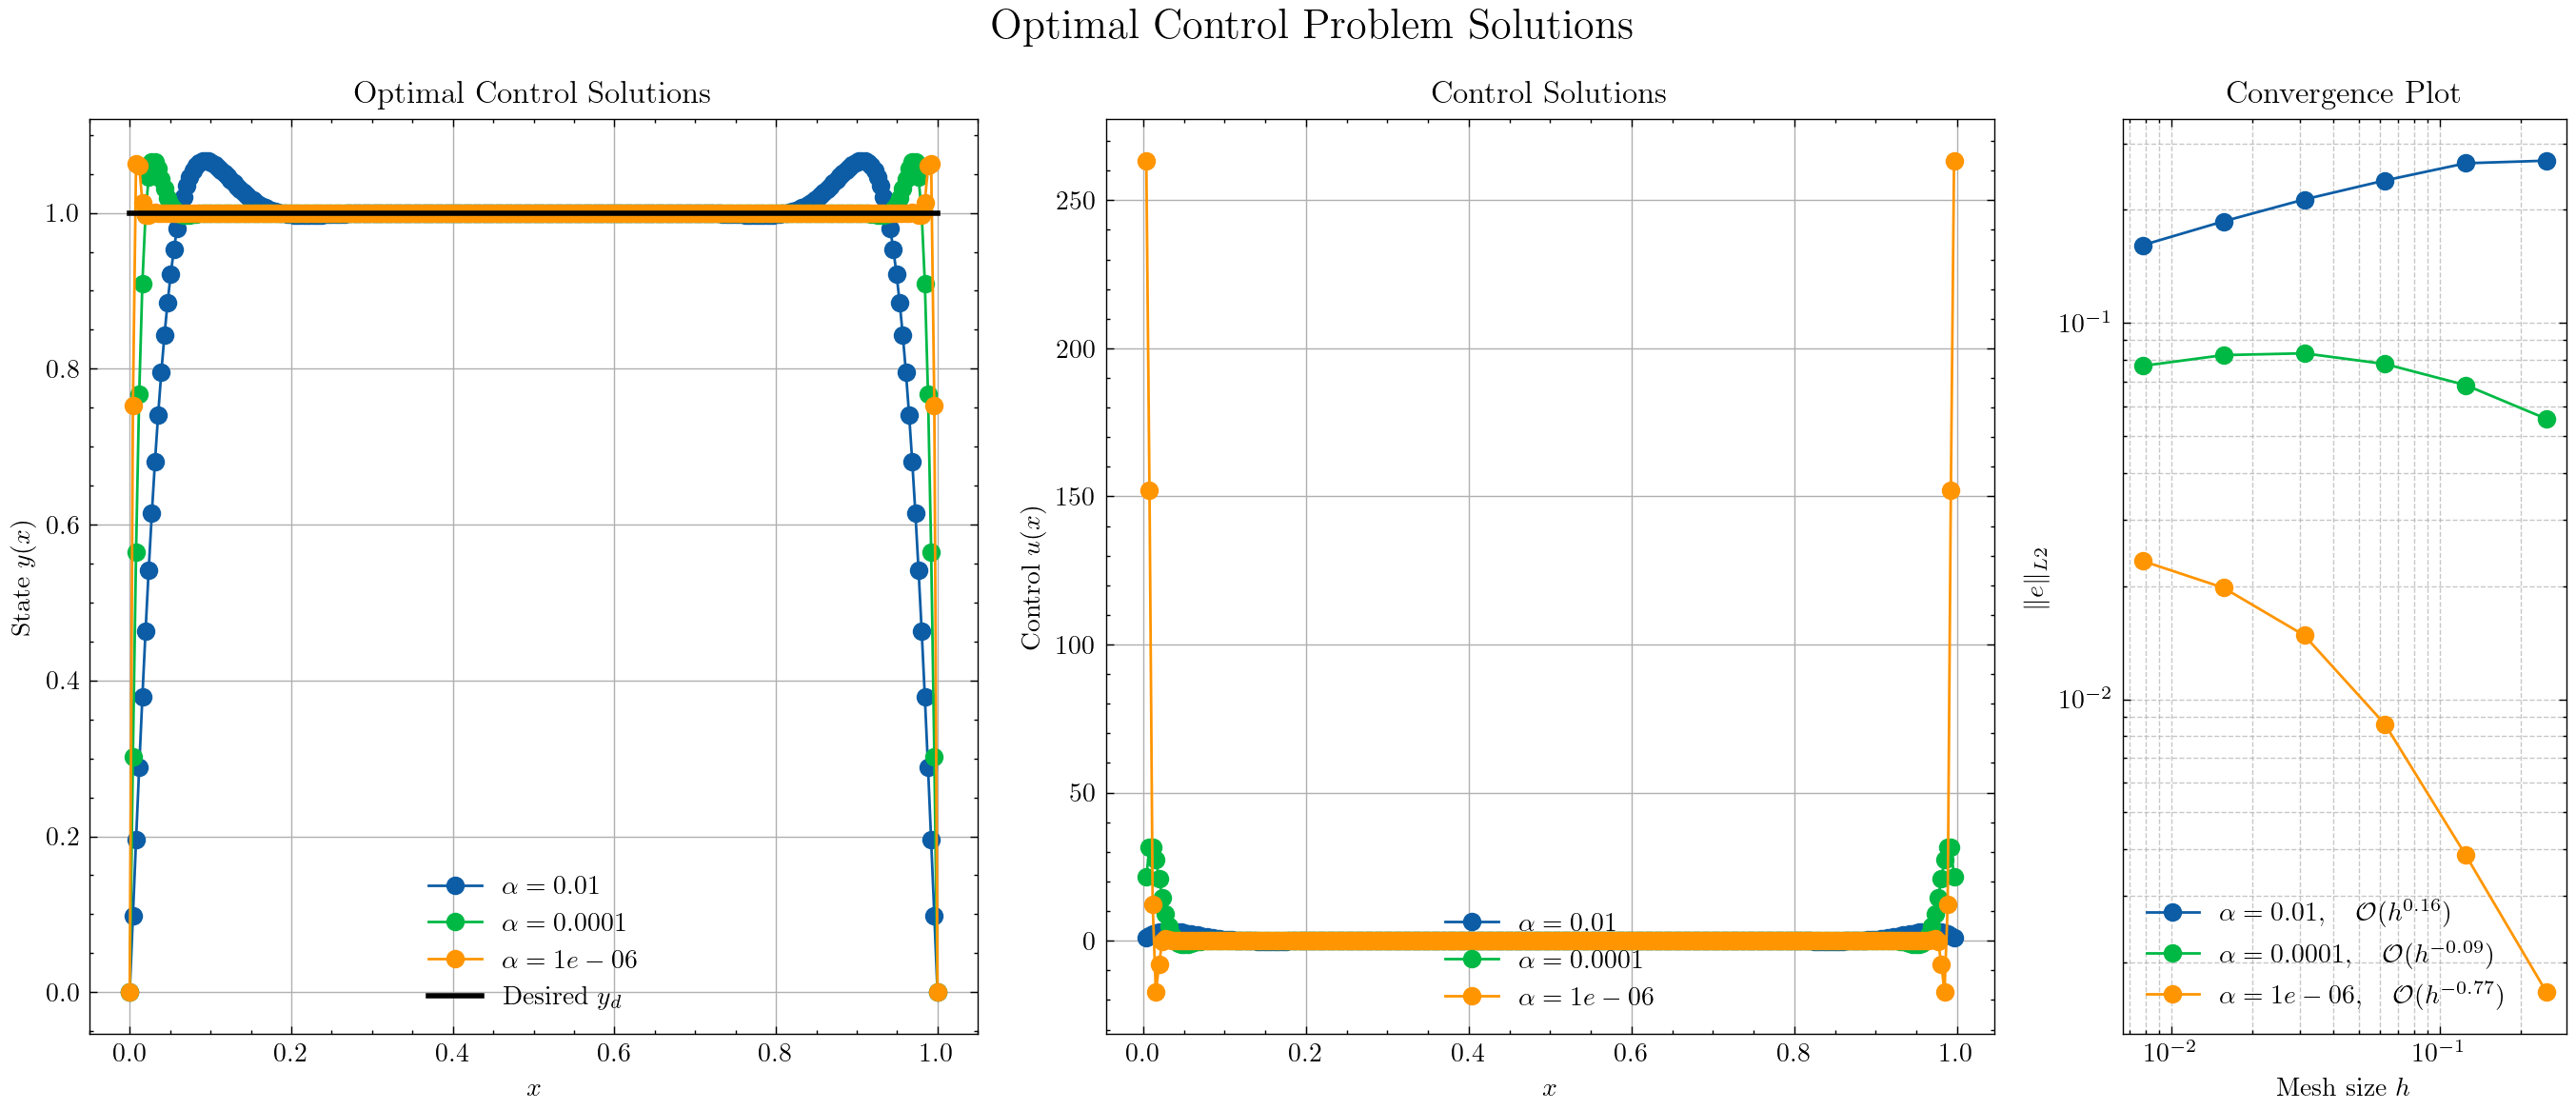



Convergence Table for yd_case3:
alpha      n          L2 Error        L2 Rate         L2 Order        H1 Error        H1 Rate         H1 Order       
0.01       4          0.260253        nan             nan             3.115391        nan             nan            
0.01       8          0.244090        0.092502        -0.678172       3.092364        0.010703        0.542903       
0.01       16         0.207382        0.235117        -0.567409       4.708724        -0.606626       0.558834       
0.01       32         0.172798        0.263207        -0.506568       7.025900        -0.577347       0.562537       
0.01       64         0.145044        0.252600        -0.464240       10.333750       -0.556609       0.561549       
0.01       128        0.121858        0.251290        -0.433819       15.016081       -0.539144       0.558348       
0.0001     4          0.122636        nan             nan             1.387773        nan             nan            
0.0001     8          

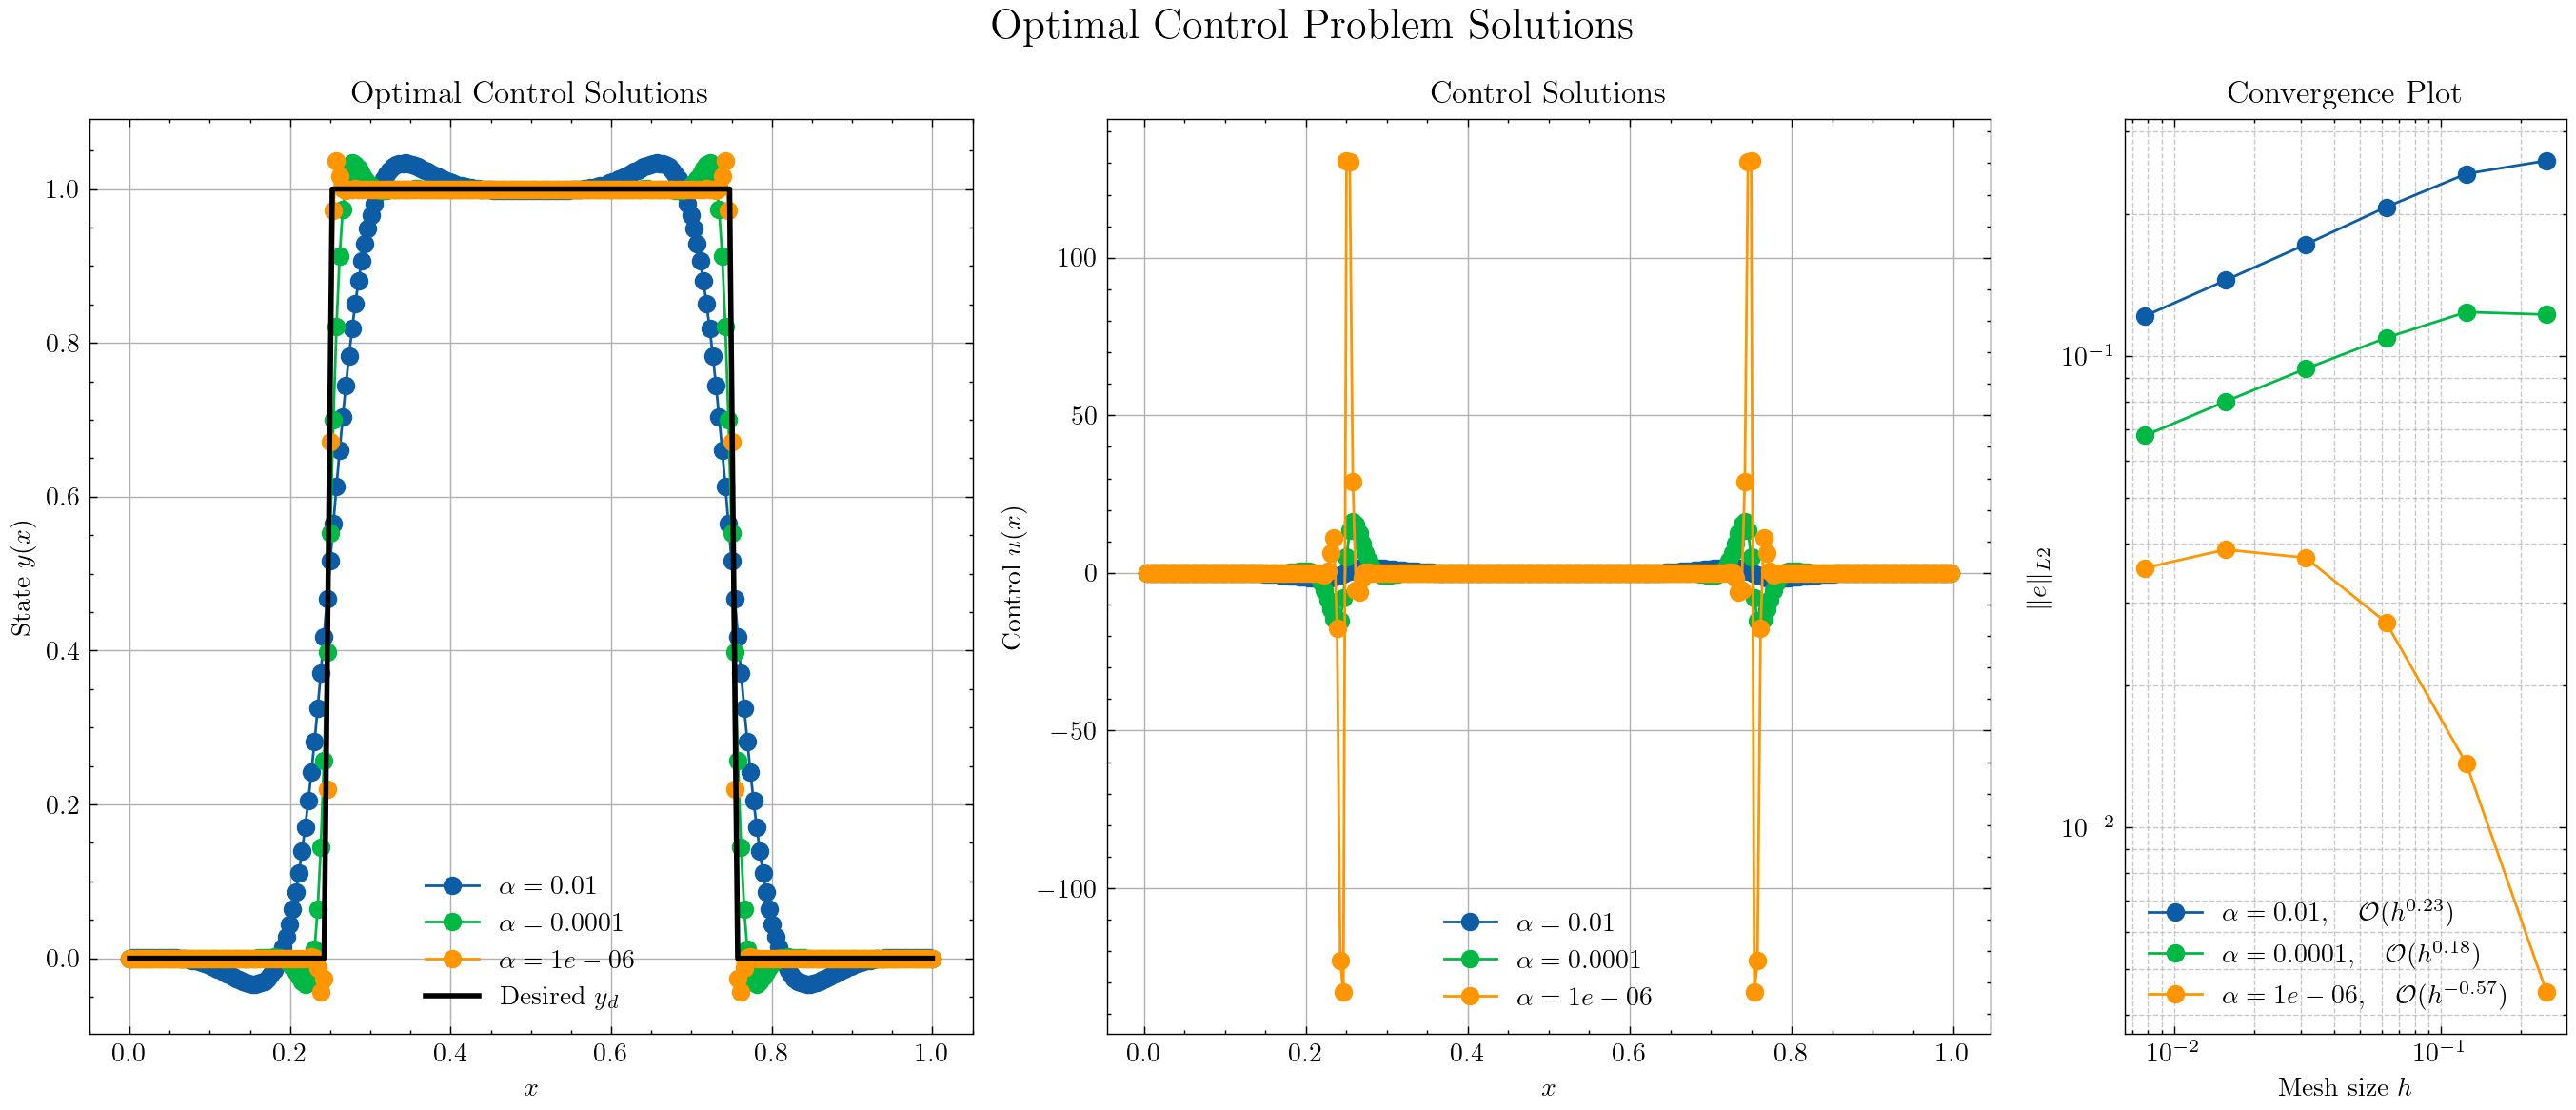

In [ ]:
from problem_2.OCP import print_convergence, plot_opt_control_multi

def yd_case1(x): 
    return 0.5 * x * (1 - x)

def yd_case2(x): 
    return np.ones_like(x)

def yd_case3(x): 
    return np.where((x >= 0.25) & (x <= 0.75), 1.0, 0.0)

cases = [(yd_case1, "Case 1"),
         (yd_case2, "Case 2"),
         (yd_case3, "Case 3")]


alphas = [1e-2, 1e-4, 1e-6]
n_elements = 50
solver = FEMSolver(n_elements)
n_vals = [4, 8, 16, 32, 64, 128]

for yd_case, title in cases:
    print_convergence(solver, yd_case, alphas, n_vals)
    plot_opt_control_multi(alphas, n_vals, yd_case, fine_mesh=100, savefig=False, name=title)
    print("\n")

